In [15]:
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
%matplotlib inline  

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['^GSPC']#,'XSP.TO']


# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2017-10-13'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between 01/01/2000 and 12/31/2016
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
close = close.reindex(all_weekdays)


close = close.dropna()
close.head(10)

C:\Users\xexx\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,^GSPC
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980
2010-01-11,1146.979980
2010-01-12,1136.219971
2010-01-13,1145.680054
2010-01-14,1148.459961
2010-01-15,1136.030029


In [7]:
sp500 = close.copy()


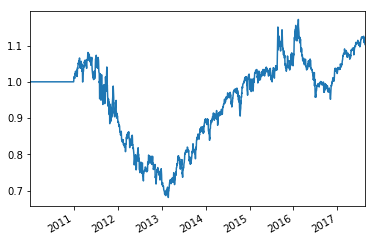

In [16]:
sp500['42d'] = np.round(sp500['^GSPC'].rolling(window=42).mean(),2)
sp500['252d'] = np.round(sp500['^GSPC'].rolling(window=252).mean(),2)
 
#create column with moving average spread differential
sp500['42-252'] = sp500['42d'] - sp500['252d']
 
#set desired number of points as threshold for spread difference and create column containing strategy 'Stance'
X = 50
sp500['Stance'] = np.where(sp500['42-252'] > X, 1, 0)
sp500['Stance'] = np.where(sp500['42-252'] < X, -1, sp500['Stance'])
sp500['Stance'].value_counts()
 
#create columns containing daily market log returns and strategy daily log returns
sp500['Market Returns'] = np.log(sp500['^GSPC'] / sp500['^GSPC'].shift(1))
sp500['Strategy'] = sp500['Market Returns'] * sp500['Stance'].shift(1)
 
#set strategy starting equity to 1 (i.e. 100%) and generate equity curve
sp500['Strategy Equity'] = sp500['Strategy'].cumsum() + 1
 
#show chart of equity curve
sp500['Strategy Equity'].plot()

In [17]:
strat = pd.DataFrame([sp500['Strategy Equity'], sp500['Strategy']]).transpose()

In [25]:
#create columns that signifies whether each days return was positive, negative or flat.
strat['win'] = (np.where(strat['Strategy'] > 0, 1,0)) 
strat['loss'] = (np.where(strat['Strategy'] < 0, 1,0)) 
strat['scratch'] = (np.where(strat['Strategy'] == 0, 1,0))
strat['losscum'] = (np.where(strat['Strategy'] < 0, 1,0)).cumsum() 
strat['scratchcum'] = (np.where(strat['Strategy'] == 0, 1,0)).cumsum() #create a columns that holds a running sum of trading days - we will use this to create our percentages later strat['days'] = (strat['wincum'] + strat['losscum'] + strat['scratchcum']) #create columns that shows the 252 day rolling sum of the winning/losing/flat days strat['rollwin'] = strat['win'].rolling(window=252).sum() strat['rollloss'] = strat['loss'].rolling(window=252).sum() strat['rollscratch'] = strat['scratch'].rolling(window=252).sum() #create columns with hit ratio and loss ratio data strat['hitratio'] = strat['wincum'] / (strat['wincum']+strat['losscum']) strat['lossratio'] = 1 - strat['hitratio'] ##create columns with rolling 252 day hit ratio and loss ratio data strat['rollhitratio'] = strat['hitratio'].rolling(window=252).mean() strat['rolllossratio'] =1 - strat['rollhitratio'] #create column with rolling 12 month return strat['roll12mret'] = strat['Strategy'].rolling(window=252).sum() #create column with average win, average loss and average daily return data strat['averagewin'] = strat['Strategy'][(strat['Strategy'] > 0)].mean() 
strat['averageloss'] = strat['Strategy'][(strat['Strategy'] < 0)].mean() 
strat['averagedailyret'] = strat['Strategy'].mean() 
 
#create column with rolling 1 year daily standard deviation and rolling 1 year annualised standard deviation
strat['roll12mstdev'] = strat['Strategy'].rolling(window=252).std() 
strat['roll12mannualisedvol'] = strat['roll12mstdev'] * sqrt(252)

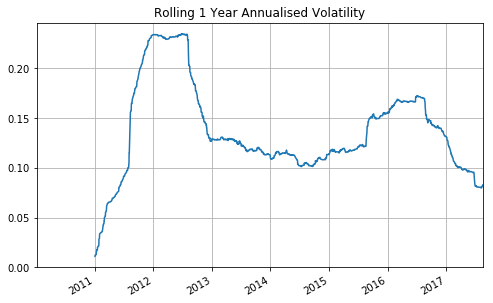

In [26]:
strat['roll12mannualisedvol'].plot(grid=True, figsize=(8,5),title='Rolling 1 Year Annualised Volatility')

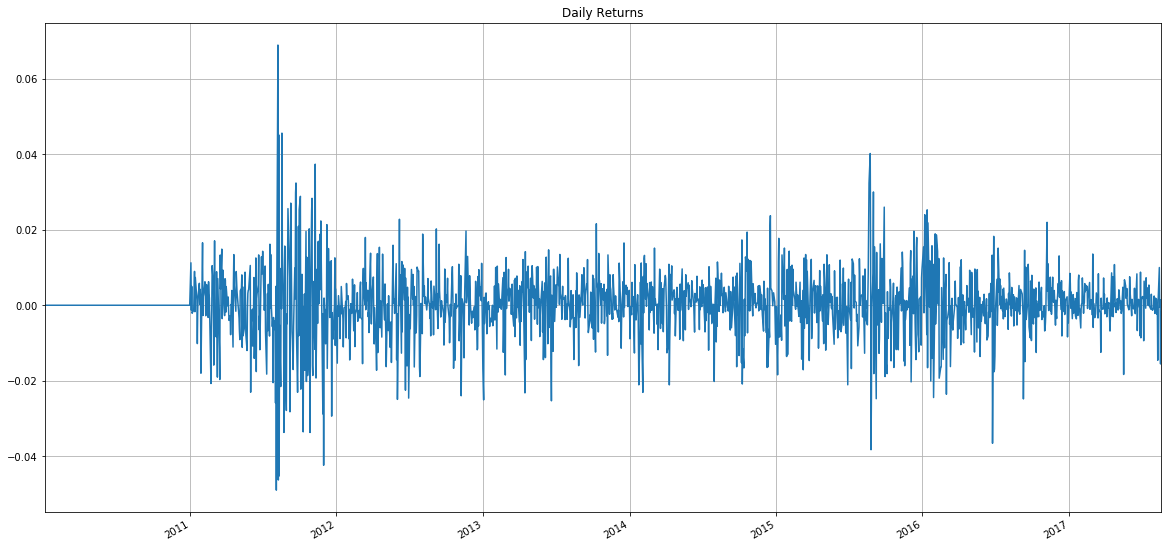

In [35]:
strat['Strategy'].plot(grid=True, figsize=(20,10),title='Daily Returns')

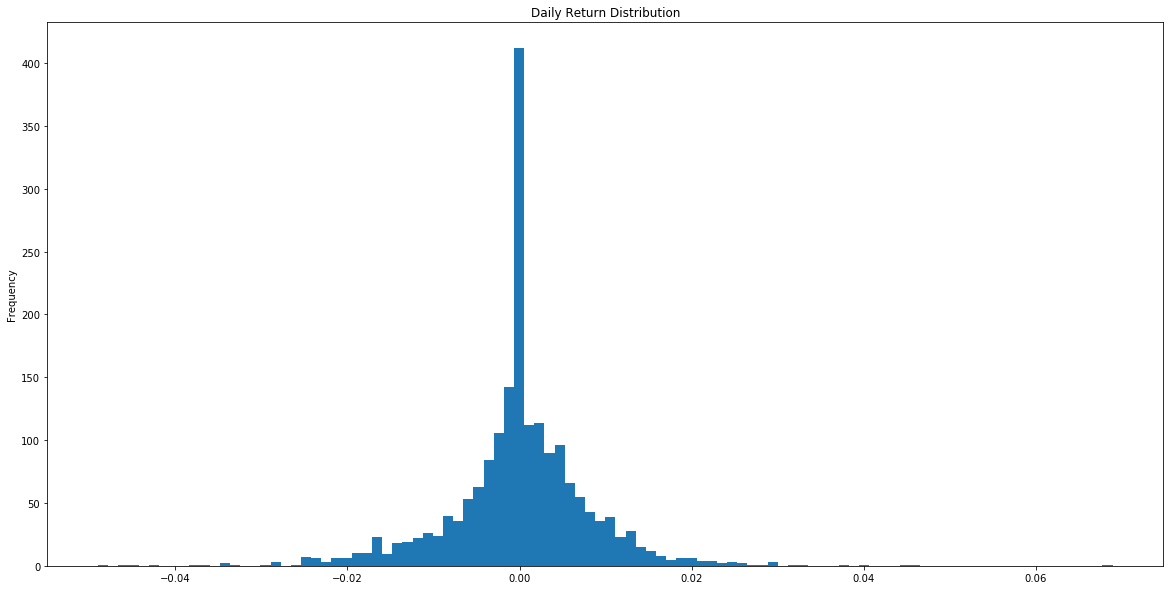

In [34]:
strat['Strategy'].plot(kind='hist',figsize=(20,10),title='Daily Return Distribution',bins=100)

In [37]:
print("Skew:",round(strat['Strategy'].skew(),4))
print("Kurtosis:",round(strat['Strategy'].kurt(),4))
#n.b. skew of normal distribution is 0, and kurtosis of normal distribution is 3).

Skew: -0.0577
Kurtosis: 6.3494


In [38]:
#Create a new DataFrame to hold our monthly data and populate it with the data from the daily returns column of our 
#original DataFrame and sum it by month
stratm = pd.DataFrame(strat['Strategy'].resample('M').sum())
 
#Build the monthly data equity curve
stratm['Strategy Equity'] = stratm['Strategy'].cumsum()+1
 
#Add a column that holds the numerical monthly index (i.e. Jan = 1, Feb = 2 etc)
stratm['month'] = stratm.index.month

In [39]:
#1) Annualised Return
 
days = (strat.index[-1] - strat.index[0]).days
cagr = ((((strat['Strategy Equity'][-1]) / strat['Strategy Equity'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")

CAGR = 1.29%


In [40]:
#2) Last 12 months Return
 
stratm['last12mret'] = stratm['Strategy'].rolling(window=12,center=False).sum()
last12mret = stratm['last12mret'][-1]
print('last 12 month return =',str(round(last12mret*100,2))+"%")

last 12 month return = 11.09%


In [41]:
#3) Volatility
voldaily = (strat['Strategy'].std()) * sqrt(252)
volmonthly = (stratm['Strategy'].std()) * sqrt(12)
print ('Annualised volatility using daily data =',str(round(voldaily,4)*100)+"%")
print ('Annualised volatility using monthly data =',str(round(volmonthly,4)*100)+"%")

Annualised volatility using daily data = 13.569999999999999%
Annualised volatility using monthly data = 11.12%


In [42]:
#4) Sharpe Ratio
dailysharpe = cagr/voldaily
monthlysharpe = cagr/volmonthly
print ('daily Sharpe =',round(dailysharpe,2))
print ('monthly Sharpe =',round(monthlysharpe,2))

daily Sharpe = 0.1
monthly Sharpe = 0.12


In [43]:
#5) Maxdrawdown
 
#Create max drawdown function
def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd  
 
 
 
mdd_daily = max_drawdown(strat['Strategy Equity'])
mdd_monthly = max_drawdown(stratm['Strategy Equity'])
print ('max drawdown daily data =',str(round(mdd_daily,4)*100)+"%")
print ('max drawdown monthly data =',str(round(mdd_monthly,4)*100)+"%")

max drawdown daily data = 0%
max drawdown monthly data = 36.35%


In [45]:
#8) Best Month Performance
bestmonth = max(stratm['Strategy'])
print ('Best month =',str(round(bestmonth,2))+"%")

Best month = 0.07%


In [48]:
#10) % of Profitable Months & % Non-Profitable Months
positive_months = len(stratm['Strategy'][stratm['Strategy'] > 0])
negative_months = len(stratm['Strategy'][stratm['Strategy'] < 0])
flatmonths = len(stratm['Strategy'][stratm['Strategy'] == 0])
perc_positive_months = positive_months / (positive_months + negative_months + flatmonths)
perc_negative_months = negative_months / (positive_months + negative_months + flatmonths)
print ('% of Profitable Months =',str(round(perc_positive_months,2)*100)+"%")
print ('% of Non-profitable Months =',str(round(perc_negative_months,2)*100)+"%")

% of Profitable Months = 48.0%
% of Non-profitable Months = 39.0%


In [49]:
#11) Number of Profitable Months/Number of Non Profitable Months
prof_unprof_months = positive_months / negative_months
print ('Number of Profitable Months/Number of Non Profitable Months',round(prof_unprof_months,2))

Number of Profitable Months/Number of Non Profitable Months 1.22


In [50]:
#12) Average Monthly Profit
av_monthly_pos = (stratm['Strategy'][stratm['Strategy'] > 0]).mean()
print ('Average Monthly Profit =',str(round(av_monthly_pos,4)*100)+"%")
 
#13) Average Monthly Loss
av_monthly_neg = (stratm['Strategy'][stratm['Strategy'] < 0]).mean()
print ('Average Monthly Loss =',str(round(av_monthly_neg*100,2))+"%")
 
#14) Average Monthly Profit/Average Monthly Loss
pos_neg_month = abs(av_monthly_pos / av_monthly_neg)
print ('Average Monthly Profit/Average Monthly Loss',round(pos_neg_month,4))

Average Monthly Profit = 2.55%
Average Monthly Loss = -2.83%
Average Monthly Profit/Average Monthly Loss 0.901


In [51]:
monthly_table = stratm[['Strategy','month']].pivot_table(stratm[['Strategy','month']], index=stratm.index, columns='month', aggfunc=np.sum).resample('A')

In [52]:
monthly_table = monthly_table.aggregate('sum')

In [53]:
#Drop the top level column index which curently shows as "Strategy"
monthly_table.columns = monthly_table.columns.droplevel()

In [54]:
#replace full date in index column with just the correspnding year
monthly_table.index = monthly_table.index.year
 
#Replace integer column headings with MMM format
monthly_table.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [55]:
monthly_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011,0.022393,0.031457,-0.001048,0.028097,-0.013593,-0.018426,-0.021708,-0.089589,0.074467,-0.102307,0.005072,-0.008497
2012,-0.042660,-0.039787,0.030851,-0.007526,-0.064699,-0.024102,-0.021171,0.019571,0.023947,-0.019988,0.002843,-0.019979
2013,-0.055662,0.011000,0.035355,0.017924,0.020550,-0.015113,0.048278,-0.031798,0.029316,0.043630,0.027663,0.023289
2014,-0.036231,0.042213,0.006908,0.006182,0.020812,0.018879,-0.015195,0.036964,-0.015635,0.022936,0.024237,-0.004197
2015,-0.031533,0.053439,-0.017549,0.008485,0.010437,-0.021236,0.024041,0.064625,0.026799,-0.079719,-0.000505,0.017686
2016,0.052068,0.004137,-0.063905,-0.002696,-0.015208,-0.076115,0.034162,-0.001220,-0.001235,-0.019617,0.033604,0.018037
2017,0.017726,0.036523,-0.000389,0.009050,0.011510,0.004802,0.019164,-0.018281,NaN,NaN,NaN,NaN
